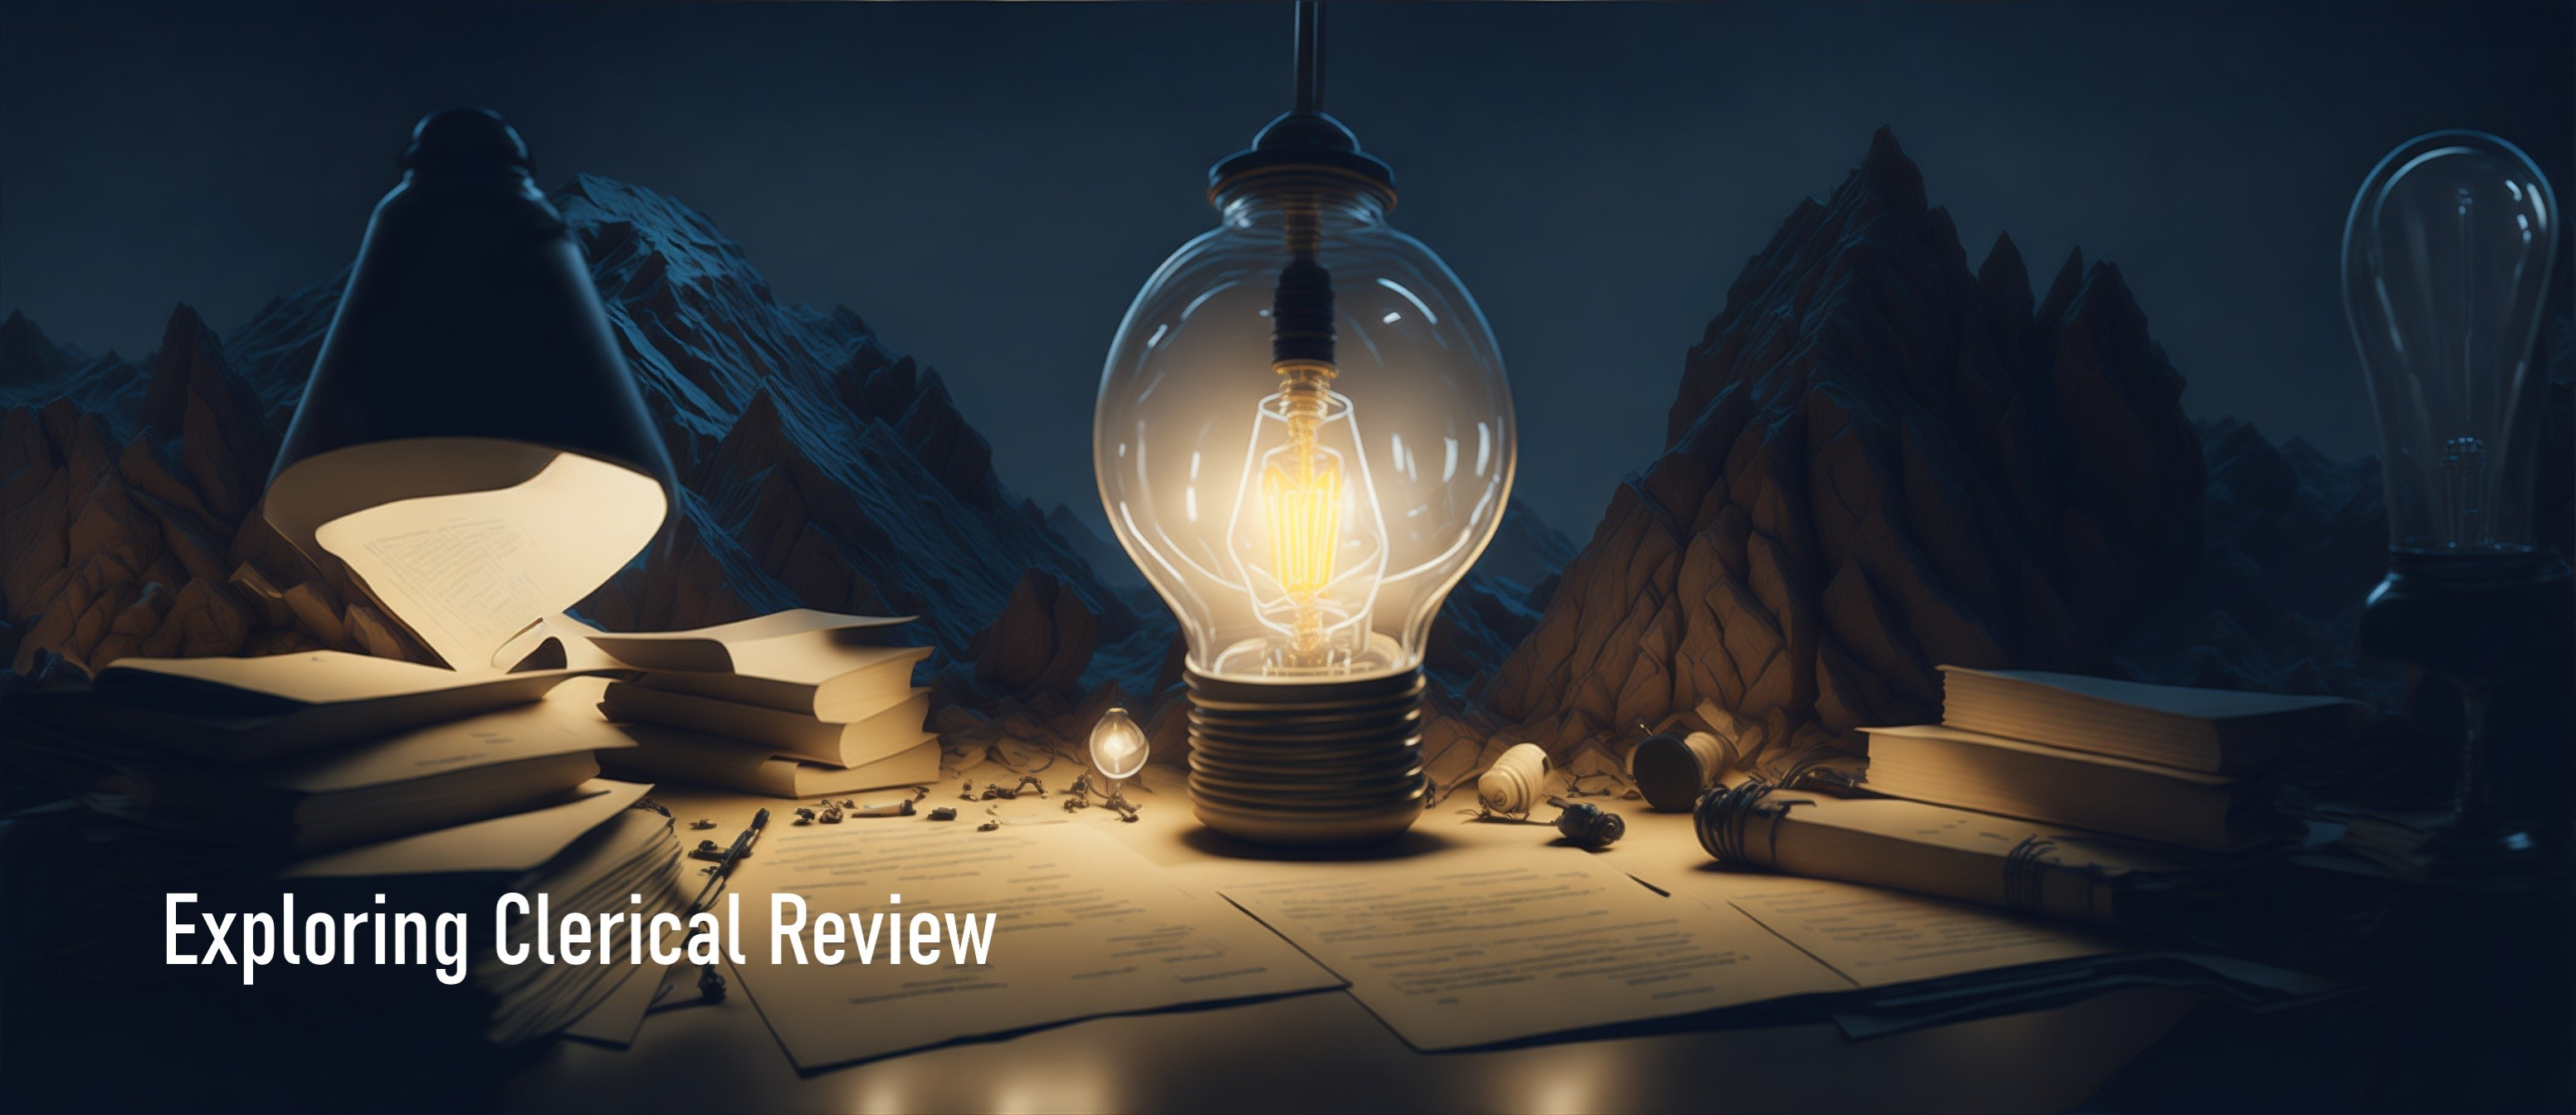

##Aims:


*   Increase linkage precision by increasing ratio of true links to false links



> $Precision = \frac{TP}{FP}$



*   Streamline automatic & manual clerical review processes



#Basic Clerical Review Method

In [1]:
# Install Packages - Note: FuzzyWuzzy is NOT currently available in NGI, but you can use the workaround below
!pip install fuzzywuzzy python-Levenshtein
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.0 MB/s eta 0:00:00


In [2]:
# Calculate levenshtein distance
# def levenshtein_distance(string1, string2):
#     size_x = len(string1) + 1
#     size_y = len(string2) + 1
#     matrix = [[0] * size_y for _ in range(size_x)]
#     for x in range(size_x):
#         matrix[x][0] = x
#     for y in range(size_y):
#         matrix[0][y] = y

#     for x in range(1, size_x):
#         for y in range(1, size_y):
#             if string1[x-1] == string2[y-1]:
#                 matrix[x][y] = min(
#                     matrix[x-1][y] + 1,
#                     matrix[x-1][y-1],
#                     matrix[x][y-1] + 1
#                 )
#             else:
#                 matrix[x][y] = min(
#                     matrix[x-1][y] + 1,
#                     matrix[x-1][y-1] + 1,
#                     matrix[x][y-1] + 1
#                 )
#     return matrix[size_x - 1][size_y - 1]

# def fuzzy_score(string1, string2):
#     levenshtein = levenshtein_distance(string1, string2)
#     longest_length = max(len(string1), len(string2))
#     return (1 - levenshtein / longest_length) * 100

In [30]:
# Load the dummy data
spine = pd.read_csv('spine.csv')
dataset = pd.read_csv('dataset.csv')
matches = pd.read_csv('matches.csv')

print('Dummy Spine')
print(spine)
print('\nDummy Dataset')
print(dataset)
print('\nLinkage Concordance')
print(matches)

Dummy Spine
   id         fn      sn  sex         dob
0   1       John    Smit    1  02/01/2011
1   2  Christine    Jobs    2  12/12/1986
2   3      Chris   Cross    1  11/11/1976
3   4        Ron      Da    1  01/05/2011
4   5        Ben   Dover    1  12/02/1996
5   6       Eddy   Jones    1  10/08/1950
6   7     Ashley   Smith    2  01/02/1933
7   8       Bill   Sykes    1  02/03/1944
8   9     Oliver   Twist    1  04/05/1945
9  10       Rose  Wilkes    2  12/11/2021

Dummy Dataset
   id         fn      sn  sex         dob
0   1       John   Smith    1  01/01/2011
1   2  Christine   Jones    2  10/09/1964
2   3      Chris   Cross    1  11/11/1976
3   4        Ron      Da    1  01/05/2011
4   5        Ben   Dover    1  12/02/1986
5   6      Eddie   Jones    1  10/08/1950
6   7     Ashley   Smith    2  01/02/1933
7   8       Bill   Sykes    1  02/03/1944
8   9     Oliver   Twist    1  04/05/1945
9  10      Rosie  Wilkes    2  12/11/2021

Linkage Concordance
   id1  id2  pass
0    1    

In [31]:
# Passes List
print('Pass 1: FN, SN, SEX, DOB')
print('Pass 2: SN, SEX, DOB')
print('Pass 3: FN, SN, SEX')
print('Pass 4: FN, SEX')

Pass 1: FN, SN, SEX, DOB
Pass 2: SN, SEX, DOB
Pass 3: FN, SN, SEX
Pass 4: FN, SEX


In [32]:
# Define your weights here. The lower the weight, the smaller the impact on the combined score
weights = {
    'fn': 0.9,
    'sn': 0.7,
    'sex': 0.3,
    'dob': 1.0,
}

# Calculating the minimum and maximum possible scores (used later to normalise weights)
min_score = 0
max_score = sum(weights.values()) * 100

In [33]:
# Join the dataframes on the relevant ID columns
df = pd.merge(matches, spine, left_on='id1', right_on='id')
df = pd.merge(df, dataset, left_on='id2', right_on='id', suffixes=('_spine', '_dataset'))

In [34]:
df

,id1,id2,pass,id_spine,fn_spine,sn_spine,sex_spine,dob_spine,id_dataset,fn_dataset,sn_dataset,sex_dataset,dob_dataset
0,1,1,4,1,John,Smit,1,02/01/2011,1,John,Smith,1,01/01/2011
1,2,2,4,2,Christine,Jobs,2,12/12/1986,2,Christine,Jones,2,10/09/1964
2,3,3,1,3,Chris,Cross,1,11/11/1976,3,Chris,Cross,1,11/11/1976
3,4,4,1,4,Ron,Da,1,01/05/2011,4,Ron,Da,1,01/05/2011
4,5,5,3,5,Ben,Dover,1,12/02/1996,5,Ben,Dover,1,12/02/1986
5,6,6,2,6,Eddy,Jones,1,10/08/1950,6,Eddie,Jones,1,10/08/1950
6,7,7,1,7,Ashley,Smith,2,01/02/1933,7,Ashley,Smith,2,01/02/1933
7,8,8,1,8,Bill,Sykes,1,02/03/1944,8,Bill,Sykes,1,02/03/1944
8,9,9,1,9,Oliver,Twist,1,04/05/1945,9,Oliver,Twist,1,04/05/1945
9,10,10,2,10,Rose,Wilkes,2,12/11/2021,10,Rosie,Wilkes,2,12/11/2021


In [35]:
 # Calculate the fuzzy scores for each feature
for feature in weights.keys():
    df[f'{feature}_score'] = df.apply(lambda row: fuzz.ratio(str(row[f'{feature}_spine']), str(row[f'{feature}_dataset'])), axis=1)
    # This second option will take longer but will work in NGI without FuzzyWuzzy
    # df[f'{feature}_score'] = df.apply(lambda row: fuzzy_score(str(row[f'{feature}_spine']), str(row[f'{feature}_dataset'])), axis=1)

# Calculate combined score (average of fuzzy scores)
df['average_score'] = df[[f'{feature}_score' for feature in weights.keys()]].mean(axis=1)

# Calculate weighted score (sum of weighted scores)
df['weighted_score'] = sum(df[f'{feature}_score'] * weight for feature, weight in weights.items())

# Normalize the weighted score
df['weighted_score'] = round(((df['weighted_score'] - min_score) / (max_score - min_score)) * 100,2)

In [36]:
df

,id1,id2,pass,id_spine,fn_spine,sn_spine,sex_spine,dob_spine,id_dataset,fn_dataset,sn_dataset,sex_dataset,dob_dataset,fn_score,sn_score,sex_score,dob_score,average_score,weighted_score
0,1,1,4,1,John,Smit,1,02/01/2011,1,John,Smith,1,01/01/2011,100,89,100,90,94.75,94.10
1,2,2,4,2,Christine,Jobs,2,12/12/1986,2,Christine,Jones,2,10/09/1964,100,67,100,60,81.75,78.97
2,3,3,1,3,Chris,Cross,1,11/11/1976,3,Chris,Cross,1,11/11/1976,100,100,100,100,100.00,100.00
3,4,4,1,4,Ron,Da,1,01/05/2011,4,Ron,Da,1,01/05/2011,100,100,100,100,100.00,100.00
4,5,5,3,5,Ben,Dover,1,12/02/1996,5,Ben,Dover,1,12/02/1986,100,100,100,90,97.50,96.67
5,6,6,2,6,Eddy,Jones,1,10/08/1950,6,Eddie,Jones,1,10/08/1950,67,100,100,100,91.75,94.50
6,7,7,1,7,Ashley,Smith,2,01/02/1933,7,Ashley,Smith,2,01/02/1933,100,100,100,100,100.00,100.00
7,8,8,1,8,Bill,Sykes,1,02/03/1944,8,Bill,Sykes,1,02/03/1944,100,100,100,100,100.00,100.00
8,9,9,1,9,Oliver,Twist,1,04/05/1945,9,Oliver,Twist,1,04/05/1945,100,100,100,100,100.00,100.00
9,10,10,2,10,Rose,Wilkes,2,12/11/2021,10,Rosie,Wilkes,2,12/11/2021,89,100,100,100,97.25,98.17


In [37]:
# Create linkage_scores df and print
linkage_scores = df[['id1', 'id2', 'pass'] + [f'{feature}_score' for feature in weights.keys()] + ['average_score', 'weighted_score']].sort_values('weighted_score', ascending=False)
print('Print all linkage scores')
linkage_scores.head(10)

Print all linkage scores


,id1,id2,pass,fn_score,sn_score,sex_score,dob_score,average_score,weighted_score
2,3,3,1,100,100,100,100,100.00,100.00
3,4,4,1,100,100,100,100,100.00,100.00
6,7,7,1,100,100,100,100,100.00,100.00
7,8,8,1,100,100,100,100,100.00,100.00
8,9,9,1,100,100,100,100,100.00,100.00
9,10,10,2,89,100,100,100,97.25,98.17
4,5,5,3,100,100,100,90,97.50,96.67
5,6,6,2,67,100,100,100,91.75,94.50
0,1,1,4,100,89,100,90,94.75,94.10
1,2,2,4,100,67,100,60,81.75,78.97


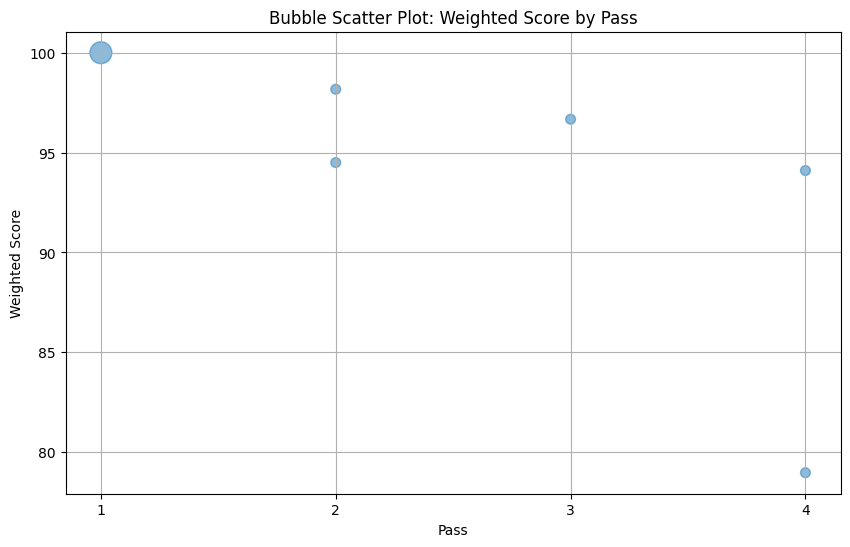

In [38]:
# Group by 'pass' and 'weighted_score', calculate the size for each group
grouped = df.groupby(['pass', 'weighted_score']).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))

# Visualise results and print chart with weighted score by pass
plt.scatter(grouped['pass'], grouped['weighted_score'], s=grouped['counts']*50, alpha=0.5)

plt.xlabel('Pass')
plt.ylabel('Weighted Score')
plt.title('Bubble Scatter Plot: Weighted Score by Pass')
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.show()

In [39]:
# Set weighted score threshold to filter records
threshold = 95
linkage_scores_filtered = linkage_scores[linkage_scores.weighted_score < threshold]
linkage_scores_filtered

,id1,id2,pass,fn_score,sn_score,sex_score,dob_score,average_score,weighted_score
5,6,6,2,67,100,100,100,91.75,94.50
0,1,1,4,100,89,100,90,94.75,94.10
1,2,2,4,100,67,100,60,81.75,78.97


In [40]:
# Filter the original dataframe for rows where 'weighted_score' is less than the threshold
original_values = df[(df['weighted_score'] < threshold)][['id1', 'id2', 'pass','fn_spine', 'fn_dataset',
                                                    'sn_spine', 'sn_dataset', 'sex_spine', 'sex_dataset',
                                                    'dob_spine', 'dob_dataset']]

original_values.columns = ['id1', 'id2', 'pass', 'first_name_1', 'first_name_2', 'surname_1', 'surname_2', 'sex_1', 'sex_2', 'dob_1', 'dob_2']
original_values

,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2
0,1,1,4,John,John,Smit,Smith,1,1,02/01/2011,01/01/2011
1,2,2,4,Christine,Christine,Jobs,Jones,2,2,12/12/1986,10/09/1964
5,6,6,2,Eddy,Eddie,Jones,Jones,1,1,10/08/1950,10/08/1950


In [41]:
# We can drill down to particular passes too
pass_filter = 4
print(f'View records from pass {pass_filter}')
original_values[original_values['pass'] == pass_filter]

View records from pass 4


,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2
0,1,1,4,John,John,Smit,Smith,1,1,02/01/2011,01/01/2011
1,2,2,4,Christine,Christine,Jobs,Jones,2,2,12/12/1986,10/09/1964


In [42]:
def accept_or_reject_matches(df):
    # Create a new column for the user's decision
    df['user_decision'] = ''

    for index, row in df.iterrows():
        print('\n--------------------')
        print(f"\nRow {index + 1} of {len(df)}:")
        print(row)

        decision = input("\nEnter '1' to accept the match, or '2' to reject it: ")
        while decision not in ['1', '2']:
            print("\nInvalid input. Please enter '1' to accept the match, or '2' to reject it.")
            decision = input("\nEnter '1' to accept the match, or '2' to reject it: ")

        df.at[index, 'user_decision'] = decision

    return df

clerical_review = accept_or_reject_matches(original_values)

accepted_matches = (clerical_review['user_decision'] == '1').sum()
rejected_matches = (clerical_review['user_decision'] == '2').sum()

print('\n----------\n')
print(f"Number of accepted matches: {accepted_matches}")
print(f"Number of rejected matches: {rejected_matches}\n")
print('Clerical Review Table')

clerical_review


--------------------

Row 1 of 3:
id1                       1
id2                       1
pass                      4
first_name_1           John
first_name_2           John
surname_1              Smit
surname_2             Smith
sex_1                     1
sex_2                     1
dob_1            02/01/2011
dob_2            01/01/2011
user_decision              
Name: 0, dtype: object

Enter '1' to accept the match, or '2' to reject it: 1

--------------------

Row 2 of 3:
id1                       2
id2                       2
pass                      4
first_name_1      Christine
first_name_2      Christine
surname_1              Jobs
surname_2             Jones
sex_1                     2
sex_2                     2
dob_1            12/12/1986
dob_2            10/09/1964
user_decision              
Name: 1, dtype: object

Enter '1' to accept the match, or '2' to reject it: 2

--------------------

Row 6 of 3:
id1                       6
id2                       6
pass       

,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2,user_decision
0,1,1,4,John,John,Smit,Smith,1,1,02/01/2011,01/01/2011,1
1,2,2,4,Christine,Christine,Jobs,Jones,2,2,12/12/1986,10/09/1964,2
5,6,6,2,Eddy,Eddie,Jones,Jones,1,1,10/08/1950,10/08/1950,1


# Advanced method - 'Best-Case'
##Uses Spine Statuses to source additional linkage information

The advanced method aims to solve two issues with the above basic method:


1.   Rather than only look at the individual linked Spine status, we can examine additional statuses from the same spine_id for additional matching information. This helps build a case that we should accept the link. <br /><br />I.e. In the link below, only two out of the four variables are matching, which will lead to a low pass uniqueness rate and questions about the link.



> | Source  | FN   | SN    | SEX | DOB        | ...  | Source | FN   | SN    | SEX | DOB        |
|---------|------|-------|-----|------------|---|--------|------|-------|-----|------------|
| Dataset | John | Smith | 1   | 01/01/2011 |  ... | Spine  | **John** | Smit | **1**   | 02/01/2011 |




<br>


---



---
<br>

> But if we expand our scope to take into account each Spine status, we can check any additional matching information that may be missing from the linked status.

>| Source  | FN   | SN    | SEX | DOB        |   | Source | FN   | SN    | SEX | DOB        |
|---------|------|-------|-----|------------|---|--------|------|-------|-----|------------|
| Dataset | John | Smith | 1   | 01/01/2011 |   | Spine  | **John** | Smit  | **1**   | 02/01/2011 |
|         |      |       |     |            |   | Spine  | J    | **Smith** | **1**  | 02/01/2011 |
|         |      |       |     |            |   | Spine  | **John** | Smit  |     | **01/01/2011** |


2.   When generating a record score, we should only use one linking variable score per group so as not to skew the weighted scores. This could be done either by selecting the max weighted var score or the mean weighted var score per group Here, we select the *max*. <br /><br />This would mean that if the link contains matching SA4 and STATE values for example, the SA4 score would be used, because the weighting is higher than STATE.

First, let's load the dummy data

In [43]:
# Load the dummy data
spine = pd.read_csv('spine_full.csv', dtype=str)
dataset = pd.read_csv('dataset_full.csv', dtype=str)
matches = pd.read_csv('matches.csv', dtype=str)

print('Dummy Spine')
print(spine)
print('\n--------\n\nDummy Dataset')
print(dataset)
print('\n--------\n\nLinkage Concordance')
print(matches)

Dummy Spine
    id         fn      sn  sex         dob  sa4 state
0    1       John    Smit    1  02/01/2011  124     1
1    1          J   Smith    1  02/01/2011  111     1
2    1       John    Smit  NaN  01/01/2011  123     1
3    2  Christine    Jobs    2  12/12/1986  234     2
4    2  Christine   Jobes    2  12/12/1986  NaN     1
5    3      Chris   Cross    1  11/11/1976  132     1
6    4        Ron      Da    1  01/05/2011  499     4
7    5        Ben   Dover    1  12/02/1996  NaN     2
8    6       Eddy   Jones    1  10/08/1950  254     2
9    7     Ashley   Smith    2  01/02/1933  943     9
10   8       Bill   Sykes    1  02/03/1944  491     4
11   9     Oliver   Twist    1  04/05/1945  299     2
12  10       Rose  Wilkes    2  12/11/2021  123     1

--------

Dummy Dataset
   id         fn      sn sex         dob  sa4 state
0   1       John   Smith   1  01/01/2011  123     1
1   2  Christine   Jones   2  10/09/1964  234     2
2   3      Chris   Cross   1  11/11/1976  131     1

Passes are defined in the previous linkage stage, but included in the clerical review process for filtering the links

In [44]:
# Passes List
print('Pass 1: FN, SN, SEX, DOB')
print('Pass 2: SN, SEX, DOB')
print('Pass 3: FN, SN, SEX')
print('Pass 4: FN, SEX')

Pass 1: FN, SN, SEX, DOB
Pass 2: SN, SEX, DOB
Pass 3: FN, SN, SEX
Pass 4: FN, SEX


Weights are important to get right as they define the importance of each linking variable and the order of priority. They are set in the form of a nested dict, but could also be defined and imported as a csv

In [45]:
# Define your weights here. The lower the weight, the smaller the impact on the combined score
weights = {
    'fn': {'fn': 0.9},
    'sn': {'sn': 0.7},
    'sex': {'sex': 0.3},
    'dob': {'dob': 1.0},
    'geo': {'sa4': 0.6, 'state': 0.4}
}

# Calculating the minimum and maximum possible scores (used later to normalise weights)
min_score = 0
max_score = round(sum(max(value for value in subvars.values()) for subvars in weights.values()) * 100)


Here, we join the imported dataframes as before

In [46]:
# Join the dataframes on the relevant ID columns
df = pd.merge(matches, spine, left_on='id1', right_on='id')
df = pd.merge(df, dataset, left_on='id2', right_on='id', suffixes=('_spine', '_dataset'))

Next, calculate the fuzzy scores for each variable

In [47]:
# Calculate the fuzzy scores for each feature
for feature, inner_dict in weights.items():
    for sub_feature, weight in inner_dict.items():
        df[f'{sub_feature}_score'] = df.apply(lambda row: fuzz.ratio(str(row[f'{sub_feature}_spine']), str(row[f'{sub_feature}_dataset'])), axis=1)


Let's take a look at our dataframe now

In [48]:
df

,id1,id2,pass,id_spine,fn_spine,sn_spine,sex_spine,dob_spine,sa4_spine,state_spine,...,sex_dataset,dob_dataset,sa4_dataset,state_dataset,fn_score,sn_score,sex_score,dob_score,sa4_score,state_score
0,1,1,4,1,John,Smit,1,02/01/2011,124,1,...,1,01/01/2011,123,1,100,89,100,90,67,100
1,1,1,4,1,J,Smith,1,02/01/2011,111,1,...,1,01/01/2011,123,1,40,100,100,90,33,100
2,1,1,4,1,John,Smit,NaN,01/01/2011,123,1,...,1,01/01/2011,123,1,100,89,0,100,100,100
3,2,2,4,2,Christine,Jobs,2,12/12/1986,234,2,...,2,10/09/1964,234,2,100,67,100,60,100,100
4,2,2,4,2,Christine,Jobes,2,12/12/1986,NaN,1,...,2,10/09/1964,234,2,100,80,100,60,0,0
5,3,3,1,3,Chris,Cross,1,11/11/1976,132,1,...,1,11/11/1976,131,1,100,100,100,100,67,100
6,4,4,1,4,Ron,Da,1,01/05/2011,499,4,...,1,01/05/2011,452,4,100,100,100,100,33,100
7,5,5,3,5,Ben,Dover,1,12/02/1996,NaN,2,...,1,12/02/1986,NaN,2,100,100,100,90,100,100
8,6,6,2,6,Eddy,Jones,1,10/08/1950,254,2,...,1,10/08/1950,254,2,67,100,100,100,100,100
9,7,7,1,7,Ashley,Smith,2,01/02/1933,943,9,...,2,01/02/1933,943,9,100,100,100,100,100,100


Now, we need to get the highest (best-case) scores for each linking variable and the corresponding value, and condense the Spine into distinct rows

In [49]:
# Initialize a dictionary to store the results
max_scores = {}

# Loop over each row in the DataFrame
for _, row in df.iterrows():
    id1 = row['id1']

    # Initialize the dictionary for the ID if it doesn't exist
    if id1 not in max_scores:
        max_scores[id1] = {
            'id2': row['id2'], 'pass': row['pass'],
        }

        for var, subvars in weights.items():
            for subvar in subvars:
                max_scores[id1][f'{subvar}_spine'] = ''
                max_scores[id1][f'{subvar}_dataset'] = ''
                max_scores[id1][f'{subvar}_score_max'] = 0

    # Check if the current score is higher than the stored maximum and update if necessary
    for var, subvars in weights.items():
        for subvar in subvars:
            if row[f'{subvar}_score'] > max_scores[id1][f'{subvar}_score_max']:
                max_scores[id1][f'{subvar}_spine'] = row[f'{subvar}_spine']
                max_scores[id1][f'{subvar}_dataset'] = row[f'{subvar}_dataset']
                max_scores[id1][f'{subvar}_score_max'] = row[f'{subvar}_score']

# Convert the dictionary to a DataFrame
df_max_scores = pd.DataFrame.from_dict(max_scores, orient='index')

# Reset the index
df_max_scores.reset_index(inplace=True)

# Rename the 'index' column to 'id1'
df_max_scores.rename(columns={'index': 'id1'}, inplace=True)


Here's what our condensed dataframe now looks like

In [50]:
df_max_scores

,id1,id2,pass,fn_spine,fn_dataset,fn_score_max,sn_spine,sn_dataset,sn_score_max,sex_spine,...,sex_score_max,dob_spine,dob_dataset,dob_score_max,sa4_spine,sa4_dataset,sa4_score_max,state_spine,state_dataset,state_score_max
0,1,1,4,John,John,100,Smith,Smith,100,1,...,100,01/01/2011,01/01/2011,100,123,123,100,1,1,100
1,2,2,4,Christine,Christine,100,Jobes,Jones,80,2,...,100,12/12/1986,10/09/1964,60,234,234,100,2,2,100
2,3,3,1,Chris,Chris,100,Cross,Cross,100,1,...,100,11/11/1976,11/11/1976,100,132,131,67,1,1,100
3,4,4,1,Ron,Ron,100,Da,Da,100,1,...,100,01/05/2011,01/05/2011,100,499,452,33,4,4,100
4,5,5,3,Ben,Ben,100,Dover,Dover,100,1,...,100,12/02/1996,12/02/1986,90,NaN,NaN,100,2,2,100
5,6,6,2,Eddy,Eddie,67,Jones,Jones,100,1,...,100,10/08/1950,10/08/1950,100,254,254,100,2,2,100
6,7,7,1,Ashley,Ashley,100,Smith,Smith,100,2,...,100,01/02/1933,01/02/1933,100,943,943,100,9,9,100
7,8,8,1,Bill,Bill,100,Sykes,Sykes,100,1,...,100,02/03/1944,02/03/1944,100,491,491,100,4,4,100
8,9,9,1,Oliver,Oliver,100,Twist,Twist,100,1,...,100,04/05/1945,04/05/1945,100,299,299,100,2,2,100
9,10,10,2,Rose,Rosie,89,Wilkes,Wilkes,100,2,...,100,12/11/2021,12/11/2021,100,123,123,100,1,1,100


Now we add columns for each variable with weighted scores

In [51]:
# Add a column for each subvariable with a weighted score
for var, subvars in weights.items():
    for subvar, weight in subvars.items():
        # Calculate weighted score
        df_max_scores[f'{subvar}_weighted_score'] = df_max_scores[f'{subvar}_score_max'] * weight


We take the max fuzzy and weighted fuzzy scores for each variable group

In [52]:
# Create new columns for max group fuzzy and weighted scores
for var, subvars in weights.items():
    # Create new column that holds the max of average scores for each group of variables
    df_max_scores[f'{var}_group_max'] = df_max_scores[[f'{subvar}_score_max' for subvar in subvars]].max(axis=1)

    # Create new column that holds the max of weighted scores for each group of variables
    df_max_scores[f'{var}_group_weighted'] = df_max_scores[[f'{subvar}_weighted_score' for subvar in subvars]].max(axis=1)


The group scores are then combined into a total mean score and a total normalised weighted score

In [53]:
# Calculate combined score (average of fuzzy scores)
df_max_scores['total_mean_score'] = df_max_scores[[f'{feature}_group_max' for feature, weight in weights.items()]].mean(axis=1)

# Calculate weighted score (sum of weighted scores)
df_max_scores['total_weighted_score'] = sum(df_max_scores[f'{feature}_group_weighted'] for feature, weight in weights.items())

# Normalize the weighted score
df_max_scores['total_weighted_score'] = round(((df_max_scores['total_weighted_score'] - min_score) / (max_score - min_score)) * 100,2)

Given our dataframe is now pretty huge, let's split it into parts to see what it contains.

Firstly, the dataset and best-case spine linking variables, and the fuzzy score.

In [54]:

df_max_scores[['id1','pass','fn_spine', 'fn_dataset', 'fn_score_max',
       'sn_spine', 'sn_dataset', 'sn_score_max', 'sex_spine', 'sex_dataset',
       'sex_score_max', 'dob_spine', 'dob_dataset', 'dob_score_max',
       'sa4_spine', 'sa4_dataset', 'sa4_score_max', 'state_spine',
       'state_dataset', 'state_score_max']]

,id1,pass,fn_spine,fn_dataset,fn_score_max,sn_spine,sn_dataset,sn_score_max,sex_spine,sex_dataset,sex_score_max,dob_spine,dob_dataset,dob_score_max,sa4_spine,sa4_dataset,sa4_score_max,state_spine,state_dataset,state_score_max
0,1,4,John,John,100,Smith,Smith,100,1,1,100,01/01/2011,01/01/2011,100,123,123,100,1,1,100
1,2,4,Christine,Christine,100,Jobes,Jones,80,2,2,100,12/12/1986,10/09/1964,60,234,234,100,2,2,100
2,3,1,Chris,Chris,100,Cross,Cross,100,1,1,100,11/11/1976,11/11/1976,100,132,131,67,1,1,100
3,4,1,Ron,Ron,100,Da,Da,100,1,1,100,01/05/2011,01/05/2011,100,499,452,33,4,4,100
4,5,3,Ben,Ben,100,Dover,Dover,100,1,1,100,12/02/1996,12/02/1986,90,NaN,NaN,100,2,2,100
5,6,2,Eddy,Eddie,67,Jones,Jones,100,1,1,100,10/08/1950,10/08/1950,100,254,254,100,2,2,100
6,7,1,Ashley,Ashley,100,Smith,Smith,100,2,2,100,01/02/1933,01/02/1933,100,943,943,100,9,9,100
7,8,1,Bill,Bill,100,Sykes,Sykes,100,1,1,100,02/03/1944,02/03/1944,100,491,491,100,4,4,100
8,9,1,Oliver,Oliver,100,Twist,Twist,100,1,1,100,04/05/1945,04/05/1945,100,299,299,100,2,2,100
9,10,2,Rose,Rosie,89,Wilkes,Wilkes,100,2,2,100,12/11/2021,12/11/2021,100,123,123,100,1,1,100


Second, it now contains the weighted score columns, because not all linking variables are created equal!

In [55]:
df_max_scores[['id1','fn_weighted_score',
       'sn_weighted_score', 'sex_weighted_score', 'dob_weighted_score',
       'sa4_weighted_score', 'state_weighted_score']]

,id1,fn_weighted_score,sn_weighted_score,sex_weighted_score,dob_weighted_score,sa4_weighted_score,state_weighted_score
0,1,90.0,70.0,80.0,100.0,60.0,40.0
1,2,90.0,56.0,80.0,60.0,60.0,40.0
2,3,90.0,70.0,80.0,100.0,40.2,40.0
3,4,90.0,70.0,80.0,100.0,19.8,40.0
4,5,90.0,70.0,80.0,90.0,60.0,40.0
5,6,60.3,70.0,80.0,100.0,60.0,40.0
6,7,90.0,70.0,80.0,100.0,60.0,40.0
7,8,90.0,70.0,80.0,100.0,60.0,40.0
8,9,90.0,70.0,80.0,100.0,60.0,40.0
9,10,80.1,70.0,80.0,100.0,60.0,40.0


Thirdly, it contains the variable group combined scores and the total mean & weighted scores.

In [56]:
df_max_scores[['id1','fn_group_max',
       'fn_group_weighted', 'sn_group_max', 'sn_group_weighted',
       'sex_group_max', 'sex_group_weighted', 'dob_group_max',
       'dob_group_weighted', 'geo_group_max', 'geo_group_weighted',
       'total_mean_score', 'total_weighted_score']]

,id1,fn_group_max,fn_group_weighted,sn_group_max,sn_group_weighted,sex_group_max,sex_group_weighted,dob_group_max,dob_group_weighted,geo_group_max,geo_group_weighted,total_mean_score,total_weighted_score
0,1,100,90.0,100,70.0,100,80.0,100,100.0,100,60.0,100.0,100.00
1,2,100,90.0,80,56.0,100,80.0,60,60.0,100,60.0,88.0,86.50
2,3,100,90.0,100,70.0,100,80.0,100,100.0,100,40.2,100.0,95.05
3,4,100,90.0,100,70.0,100,80.0,100,100.0,100,40.0,100.0,95.00
4,5,100,90.0,100,70.0,100,80.0,90,90.0,100,60.0,98.0,97.50
5,6,67,60.3,100,70.0,100,80.0,100,100.0,100,60.0,93.4,92.58
6,7,100,90.0,100,70.0,100,80.0,100,100.0,100,60.0,100.0,100.00
7,8,100,90.0,100,70.0,100,80.0,100,100.0,100,60.0,100.0,100.00
8,9,100,90.0,100,70.0,100,80.0,100,100.0,100,60.0,100.0,100.00
9,10,89,80.1,100,70.0,100,80.0,100,100.0,100,60.0,97.8,97.52


Let's condense this wide dataframe into a few of the most important columns, and generate a visualisation showing weighted scores by pass

In [57]:
# Create linkage_scores df and print
linkage_scores = df_max_scores[['id1', 'id2', 'pass'] + [f'{feature}_group_max' for feature, weight in weights.items()] + ['total_mean_score', 'total_weighted_score']].sort_values('total_weighted_score', ascending=False)


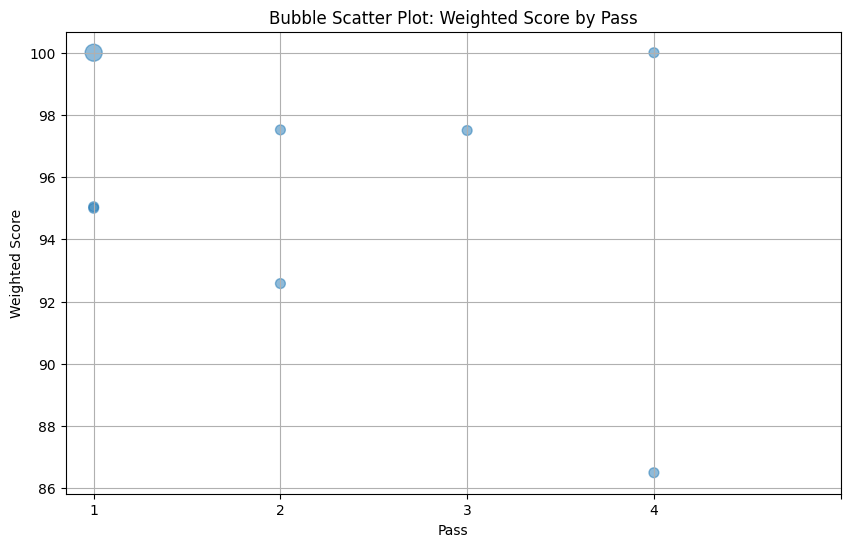

In [58]:
# Group by 'pass' and 'weighted_score', calculate the size for each group
grouped = df_max_scores.groupby(['pass', 'total_weighted_score']).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))

# Visualise results and print chart with weighted score by pass
plt.scatter(grouped['pass'], grouped['total_weighted_score'], s=grouped['counts']*50, alpha=0.5)

plt.xlabel('Pass')
plt.ylabel('Weighted Score')
plt.title('Bubble Scatter Plot: Weighted Score by Pass')
plt.xticks([0,1,2,3,4])
plt.grid(True)
plt.show()

We can filter the dataframe to give us any records where the score is under a certain threshold and show the original dataset and best-case Spine values side by side for further review

In [59]:
# Set weighted score threshold to filter records
threshold = 95
linkage_scores_filtered = linkage_scores[linkage_scores.total_weighted_score < threshold]

# Lets see the original values side by side
original_values = df_max_scores[(df_max_scores['total_weighted_score'] < threshold)][['id1', 'id2', 'pass','fn_spine', 'fn_dataset',
                                                    'sn_spine', 'sn_dataset', 'sex_spine', 'sex_dataset',
                                                    'dob_spine', 'dob_dataset', 'sa4_spine','sa4_dataset',
                                                    'state_spine','state_dataset']].reset_index(drop=True)

original_values.columns = ['id1', 'id2', 'pass', 'first_name_1', 'first_name_2', 'surname_1', 'surname_2', 'sex_1', 'sex_2', 'dob_1', 'dob_2',
                           'sa4_1', 'sa4_2', 'state_1', 'state_2']
original_values

,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2,sa4_1,sa4_2,state_1,state_2
0,2,2,4,Christine,Christine,Jobes,Jones,2,2,12/12/1986,10/09/1964,234,234,2,2
1,6,6,2,Eddy,Eddie,Jones,Jones,1,1,10/08/1950,10/08/1950,254,254,2,2


We can drill down to particular passes for review. Here, we select records that linked in pass #4

In [60]:
# We can drill down to particular passes too
pass_filter = '4'
print(f'View records from pass {pass_filter}')
original_values[original_values['pass'] == pass_filter]

View records from pass 4


,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2,sa4_1,sa4_2,state_1,state_2
0,2,2,4,Christine,Christine,Jobes,Jones,2,2,12/12/1986,10/09/1964,234,234,2,2


This code block contains a function to conduct a manual clerical review. The user can decide to accept or reject the link, with the results recorded in a new column called 'user_decision'

In [61]:
def accept_or_reject_matches(df):
    # Create a new column for the user's decision
    df['user_decision'] = ''

    for index, row in df.iterrows():
        print('\n--------------------')
        print(f"\nRow {index + 1} of {len(df)}:")
        print(row)

        decision = input("\nEnter '1' to accept the match, or '2' to reject it: ")
        while decision not in ['1', '2']:
            print("\nInvalid input. Please enter '1' to accept the match, or '2' to reject it.")
            decision = input("\nEnter '1' to accept the match, or '2' to reject it: ")

        df.at[index, 'user_decision'] = decision

    return df

clerical_review = accept_or_reject_matches(original_values)

accepted_matches = (clerical_review['user_decision'] == '1').sum()
rejected_matches = (clerical_review['user_decision'] == '2').sum()

print('\n----------\n')
print(f"Number of accepted matches: {accepted_matches}")
print(f"Number of rejected matches: {rejected_matches}\n")
print('Clerical Review Table')

clerical_review


--------------------

Row 1 of 2:
id1                       2
id2                       2
pass                      4
first_name_1      Christine
first_name_2      Christine
surname_1             Jobes
surname_2             Jones
sex_1                     2
sex_2                     2
dob_1            12/12/1986
dob_2            10/09/1964
sa4_1                   234
sa4_2                   234
state_1                   2
state_2                   2
user_decision              
Name: 0, dtype: object

Enter '1' to accept the match, or '2' to reject it: 2

--------------------

Row 2 of 2:
id1                       6
id2                       6
pass                      2
first_name_1           Eddy
first_name_2          Eddie
surname_1             Jones
surname_2             Jones
sex_1                     1
sex_2                     1
dob_1            10/08/1950
dob_2            10/08/1950
sa4_1                   254
sa4_2                   254
state_1                   2
state_2     

,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2,sa4_1,sa4_2,state_1,state_2,user_decision
0,2,2,4,Christine,Christine,Jobes,Jones,2,2,12/12/1986,10/09/1964,234,234,2,2,2
1,6,6,2,Eddy,Eddie,Jones,Jones,1,1,10/08/1950,10/08/1950,254,254,2,2,1


##Next Steps:


*   Transfer the python script to NGI and rewrite
*   Determine an appropriate weighting for missing values (currently 0)

